# Evaluation Metrics

The purpose of this notebook is to provide evaluation and visualization for the models we created to determine their capacity to recognize people in socially-distanced and not socially-distanced crowds.

TODO 
- Create unaugmented test set
- Save confusion matrices and other visual metrics for both test sets

In [19]:
%%javascript
IPython.notebook.clear_all_output();

<IPython.core.display.Javascript object>

ERROR! Session/line number was not unique in database. History logging moved to new session 208


In [3]:
import sys
import tensorflow as tf
import tensorflow.keras as keras

print("Python version %s.%s.%s" % sys.version_info[:3])
print("Tensorflow version %s" % tf.__version__)
print("Keras version %s" % keras.__version__)

from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import resnet50, vgg16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, load_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

Python version 3.7.13
Tensorflow version 2.1.0
Keras version 2.2.4-tf


## Load models

In [4]:
# Load models
model_resnet50 = resnet50.ResNet50(weights='imagenet', include_top=False)
model_vgg16 = vgg16.VGG16(weights='imagenet', include_top=False)

model_trained_resnet50 = load_model("resnet50.h5")
model_trained_vgg16 = load_model("vgg16.h5")

# Define constants
# TODO: placeholders actual values are augmentation specific
img_width = 224
classes = ["not_distanced", "distanced"]

2022-04-14 18:06:08.139161: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2022-04-14 18:06:08.160320: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2804000000 Hz
2022-04-14 18:06:08.160689: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55988aba8660 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-14 18:06:08.160734: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-04-14 18:06:08.160795: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
def get_image(filename):
    original = load_img(filename, target_size=(img_width, img_width))
    numpy_image = img_to_array(original)
    return np.uint8(numpy_image)

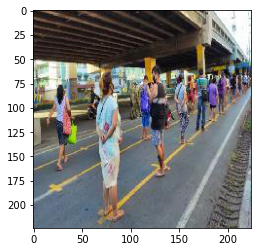

In [6]:
test_img = get_image('data/test/images/1247.jpg')
plt.imshow(np.uint8(test_img))
plt.show()

In [7]:
from tensorflow.keras.applications.imagenet_utils import decode_predictions

image_batch = np.expand_dims(test_img, axis=0)
image_batch = np.copy(image_batch)

image_batch = resnet50.preprocess_input(image_batch)
feature_input = model_resnet50.predict(image_batch)
predictions = model_trained_resnet50.predict(feature_input)
pos = np.argmax(predictions)
classes[pos]

'distanced'

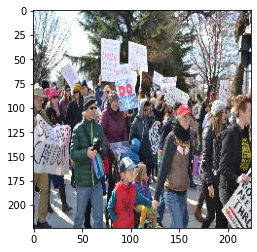

In [8]:
test_img = get_image('data/test/images/1232.jpg')
plt.imshow(np.uint8(test_img))
plt.show()

In [9]:
image_batch = np.expand_dims(test_img, axis=0)
image_batch = np.copy(image_batch)

image_batch = resnet50.preprocess_input(image_batch)
feature_input = model_resnet50.predict(image_batch)
predictions = model_trained_resnet50.predict(feature_input)
pos = np.argmax(predictions)
classes[pos]

'not_distanced'

In [10]:
num_test_images = 310

x_test = np.zeros((num_test_images, img_width, img_width, 3), dtype=np.uint8)
y_test = np.zeros((num_test_images, 2), dtype=np.uint8)

test_labels = pd.read_csv('data/test/labels.csv', names=["id","distancing"], dtype={'id': str, 'distancing': np.uint8})
test_labels.head()

,id,distancing
0,1230,0
1,1231,1
2,1232,0
3,1233,0
4,1234,1


In [11]:
for i in range(num_test_images):
    # print('test/%s.jpg' % labels['id'][i])
    x_test[i] = get_image('data/test/images/%s.jpg' % test_labels['id'][i])
    # print(test_labels['distancing'][i])
    pos = test_labels['distancing'][i] # recall that breed is the array of classes
    y_test[i][pos] = 1
    # print(y_train[i])
    if(i % 100 == 0): print(i, 'images loaded')

0 images loaded
100 images loaded
200 images loaded
300 images loaded


In [12]:
x_test = resnet50.preprocess_input(x_test)
x_test.shape

(310, 224, 224, 3)

In [13]:
feature_input = model_resnet50.predict(x_test)
predictions = model_trained_resnet50.predict(feature_input)
type(predictions)

numpy.ndarray

In [14]:
preds = np.zeros((num_test_images, 2), dtype=np.uint8)
preds[np.arange(predictions.shape[0]), np.argmax(predictions, axis=1)] = 1
preds = np.nonzero(preds)
preds = preds[1]
preds[:5]

array([0, 1, 0, 0, 1])

In [15]:
y_truth = np.zeros((num_test_images, 2), dtype=np.uint8)
y_truth[np.arange(y_test.shape[0]), np.argmax(y_test, axis=1)] = 1
y_truth = np.nonzero(y_truth)
y_truth = y_truth[1]
y_truth[:5]

array([0, 1, 0, 0, 1])

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
matrix = confusion_matrix(y_truth, preds)
print(matrix)

[[197   3]
 [ 11  99]]


In [17]:
precision = precision_score(y_truth, preds)
print('Precision: %f' % precision)
recall = recall_score(y_truth, preds)
print('Recall: %f' % recall)
f1 = f1_score(y_truth, preds)
print('F1 score: %f' % f1)

Precision: 0.970588
Recall: 0.900000
F1 score: 0.933962


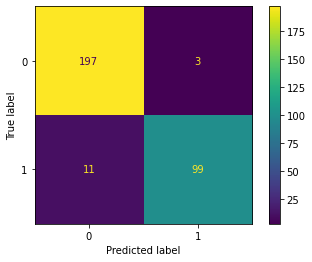

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_truth, preds)

In [19]:
""" from matplotlib import cm
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore, CategoricalScore """

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/laurthompson0/.miniconda3/envs/cs665final/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_28629/1390756349.py", line 2, in <module>
    from tf_keras_vis.saliency import Saliency
ModuleNotFoundError: No module named 'tf_keras_vis'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/laurthompson0/.miniconda3/envs/cs665final/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ModuleNotFoundError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/laurthompson0/.miniconda3/envs/cs665final/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1101, in get_

In [ ]:
""" saliency_img = get_image('data/test/images/1247.jpg')
saliency_imgs = []
for num in range(16):    
    saliency_imgs.append(saliency_img)
saliency_imgs = np.asarray(saliency_imgs)
print(saliency_imgs.shape)
scores = [281, 282, 283, 284, 286, 287, 366, 367, 341, 273, 270, 470, 188, 130, 361, 364]
score = CategoricalScore(scores) """

(16, 224, 224, 3)


In [ ]:
""" X = resnet50.preprocess_input(saliency_imgs)
replace2linear = ReplaceToLinear() """

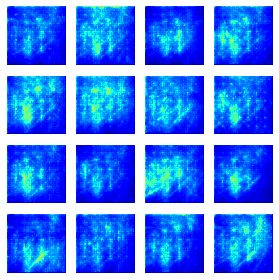

In [ ]:
""" saliency = Saliency(model_resnet50, model_modifier=replace2linear, clone=True)

saliency_map = saliency(score, X, smooth_samples=20, smooth_noise=0.20)
f, ax = plt.subplots(nrows=4, ncols=4, figsize=(4, 4))
count = 0
for row in range(4):
    for col in range(4):
        ax[row, col].imshow(saliency_map[count], cmap='jet')
        ax[row, col].axis('off')
        count+=1
plt.tight_layout()
plt.show() """

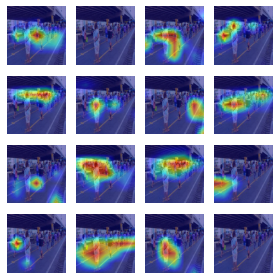

In [ ]:
""" # Create Gradcam object
gradcam = Gradcam(model_resnet50, model_modifier=replace2linear, clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score, X, penultimate_layer=-1)

f, ax = plt.subplots(nrows=4, ncols=4, figsize=(4, 4))
count = 0
for row in range(4):
    for col in range(4):
        heatmap = np.uint8(cm.jet(cam[count])[..., :3] * 255)
        ax[row, col].imshow(get_image('data/test/images/1247.jpg'))
        ax[row, col].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
        ax[row, col].axis('off')
        count+=1
plt.tight_layout()
plt.show() """

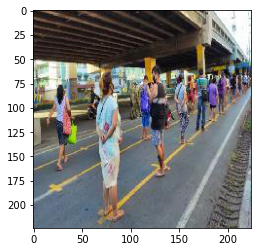

In [ ]:
test_img = get_image('data/test/images/1247.jpg')
plt.imshow(np.uint8(test_img))
plt.show()

In [ ]:
image_batch = np.expand_dims(test_img, axis=0)
image_batch = np.copy(image_batch)

image_batch = vgg16.preprocess_input(image_batch)
feature_input = model_vgg16.predict(image_batch)
predictions = model_trained_vgg16.predict(feature_input)
pos = np.argmax(predictions)
classes[pos]

'distanced'

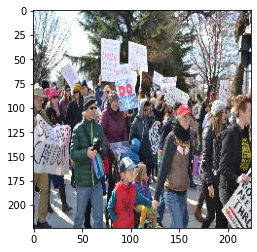

In [ ]:
test_img = get_image('data/test/images/1232.jpg')
plt.imshow(np.uint8(test_img))
plt.show()

In [ ]:
image_batch = np.expand_dims(test_img, axis=0)
image_batch = np.copy(image_batch)

image_batch = vgg16.preprocess_input(image_batch)
feature_input = model_vgg16.predict(image_batch)
predictions = model_trained_vgg16.predict(feature_input)
pos = np.argmax(predictions)
classes[pos]

'not_distanced'

In [ ]:
x_test = vgg16.preprocess_input(x_test)
x_test.shape

(310, 224, 224, 3)

In [ ]:
feature_input = model_vgg16.predict(x_test)
predictions = model_trained_vgg16.predict(feature_input)
type(predictions)

numpy.ndarray

In [ ]:
preds = np.zeros((num_test_images, 2), dtype=np.uint8)
preds[np.arange(predictions.shape[0]), np.argmax(predictions, axis=1)] = 1
preds = np.nonzero(preds)
preds = preds[1]
preds[:5]

array([0, 1, 0, 0, 1])

In [ ]:
matrix = confusion_matrix(y_truth, preds)
print(matrix)

[[189  11]
 [ 13  97]]


In [ ]:
precision = precision_score(y_truth, preds)
print('Precision: %f' % precision)
recall = recall_score(y_truth, preds)
print('Recall: %f' % recall)
f1 = f1_score(y_truth, preds)
print('F1 score: %f' % f1)

Precision: 0.898148
Recall: 0.881818
F1 score: 0.889908


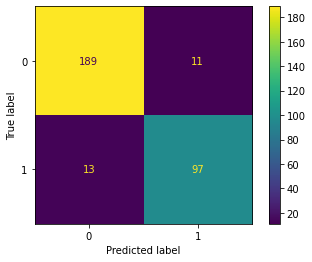

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_truth, preds)

In [ ]:
X = vgg16.preprocess_input(saliency_imgs)
replace2linear = ReplaceToLinear()

(16, 224, 224, 3)


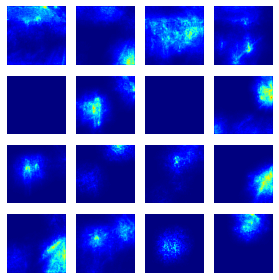

In [ ]:
saliency = Saliency(model_vgg16, model_modifier=replace2linear, clone=True)

saliency_map = saliency(score, X, smooth_samples=20, smooth_noise=0.20)
f, ax = plt.subplots(nrows=4, ncols=4, figsize=(4, 4))
count = 0
for row in range(4):
    for col in range(4):
        ax[row, col].imshow(saliency_map[count], cmap='jet')
        ax[row, col].axis('off')
        count+=1
plt.tight_layout()
plt.show()

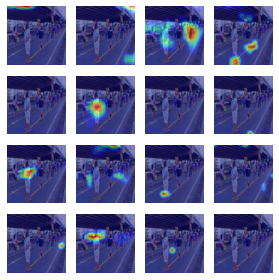

In [ ]:
# Create Gradcam object
gradcam = Gradcam(model_vgg16, model_modifier=replace2linear, clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score, X, penultimate_layer=-1)

f, ax = plt.subplots(nrows=4, ncols=4, figsize=(4, 4))
count = 0
for row in range(4):
    for col in range(4):
        heatmap = np.uint8(cm.jet(cam[count])[..., :3] * 255)
        ax[row, col].imshow(get_image('data/test/images/1247.jpg'))
        ax[row, col].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
        ax[row, col].axis('off')
        count+=1
plt.tight_layout()
plt.show()